impor library

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from pathlib import Path

mount google drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


mendefinisikan variabel Path dari dataset (train,test,valid)

In [0]:
PATH = Path('/content/gdrive/My Drive/Malaria/')
train = PATH / 'train'
test = PATH / 'test'
valid = PATH / 'valid'

load dataset menggunakan ImageDataBunch dari folder dataset yang sebelumnya sudah dipisahkan berdasarkan porsi dataset(train 80%,test & valid masing - masing 10%), dataset di-transformasi diputar segala arah secara vertikal, horizontal dan 90 derajat dari citra asli dan diubah menjadi ukuran 224x224, batch size = 64

In [0]:
data = ImageDataBunch.from_folder(PATH, 
                                  train="train", #90%
                                  test="test", #1337 images per label (10%)
                                  valid="valid", #1337 images per label (10%)
                                  ds_tfms=get_transforms(do_flip = True, flip_vert = True, max_warp=0),
                                  # dataset di-transformasi diputar segala arah secara vertikal, horizontal dan 90 derajat dari citra asli 
                                  size=224,bs=64, 
                                  num_workers=1).normalize(imagenet_stats)

In [0]:
data

ImageDataBunch;

Train: LabelList (22050 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Parasitized,Parasitized,Parasitized,Parasitized,Parasitized
Path: /content/gdrive/My Drive/Malaria;

Valid: LabelList (2754 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Uninfected,Uninfected,Uninfected,Uninfected,Uninfected
Path: /content/gdrive/My Drive/Malaria;

Test: LabelList (2754 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/gdrive/My Drive/Malaria

melihat dataset yang sudah di-load & label

Classes: 
 ['Parasitized', 'Uninfected']


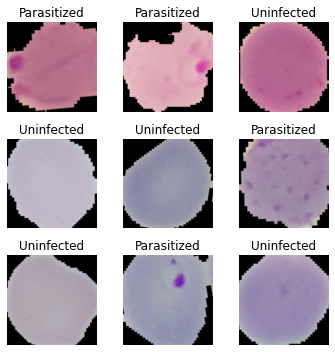

In [0]:
print(f'Classes: \n {data.classes}')
data.show_batch(rows=3, figsize=(5,5))

mendefinisikan model ResNet34

In [0]:
model = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Melatih model menggunakan fungsi fit one cycle (https://docs.fast.ai/basic_train.html#fit_one_cycle)

In [0]:
model.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.237067,0.149296,0.944081,3:10:32
1,0.170146,0.104557,0.964778,05:01
2,0.147626,0.103955,0.962963,04:48
3,0.139671,0.094986,0.964415,04:48


Mencari learning rate

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 1.10E-07


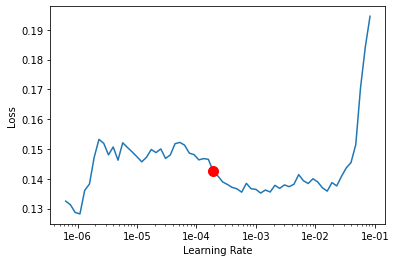

In [0]:
model.lr_find()
model.recorder.plot(suggestion=True)
min_grad_lr = model.recorder.min_grad_lr

melatih model menggunakan saran learning rate

In [0]:
model.fit_one_cycle(2,min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.123358,0.087276,0.966231,04:51
1,0.127885,0.083826,0.966957,04:49


melatih model menggunakan saran learning rate dengan epoch yg lebih besar (penentuan epoch dari intuisi)

In [0]:
model.fit_one_cycle(6,min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.130467,0.081105,0.966231,04:46
1,0.124476,0.081095,0.967683,04:45
2,0.114209,0.078057,0.969862,04:46
3,0.119452,0.075295,0.968773,04:45
4,0.113938,0.076390,0.970225,04:44
5,0.117066,0.076034,0.970588,04:44


menyimpan model hasil pelatihan

In [0]:
model.save('970588-malaria')

melakukan unfreeze pada model ResNet34 agar bisa melakukan pelatihan terhadap semua layer pada model

In [0]:
model.unfreeze()

melakukan pelatihan kembali & melatih semua layer pada ResNet34

In [0]:
model.fit_one_cycle(6,min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.120679,0.096648,0.967320,04:55
1,0.139060,0.095731,0.972404,04:54
2,0.115747,0.090037,0.969862,04:59
3,0.101562,0.076897,0.970951,05:02
4,0.088370,0.061409,0.976398,04:58
5,0.078202,0.057081,0.977124,04:58


In [0]:
model.save('977124-malaria')

In [0]:
model.freeze()

In [0]:
model.load('977124-malaria')

Learner(data=ImageDataBunch;

Train: LabelList (22050 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Parasitized,Parasitized,Parasitized,Parasitized,Parasitized
Path: /content/gdrive/My Drive/Malaria;

Valid: LabelList (2754 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Uninfected,Uninfected,Uninfected,Uninfected,Uninfected
Path: /content/gdrive/My Drive/Malaria;

Test: LabelList (2754 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/gdrive/My Drive/Malaria, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): 

In [0]:
preds,y,losses = model.get_preds(DatasetType.Test,with_loss=True)
interp = ClassificationInterpretation(model, preds, y, losses)

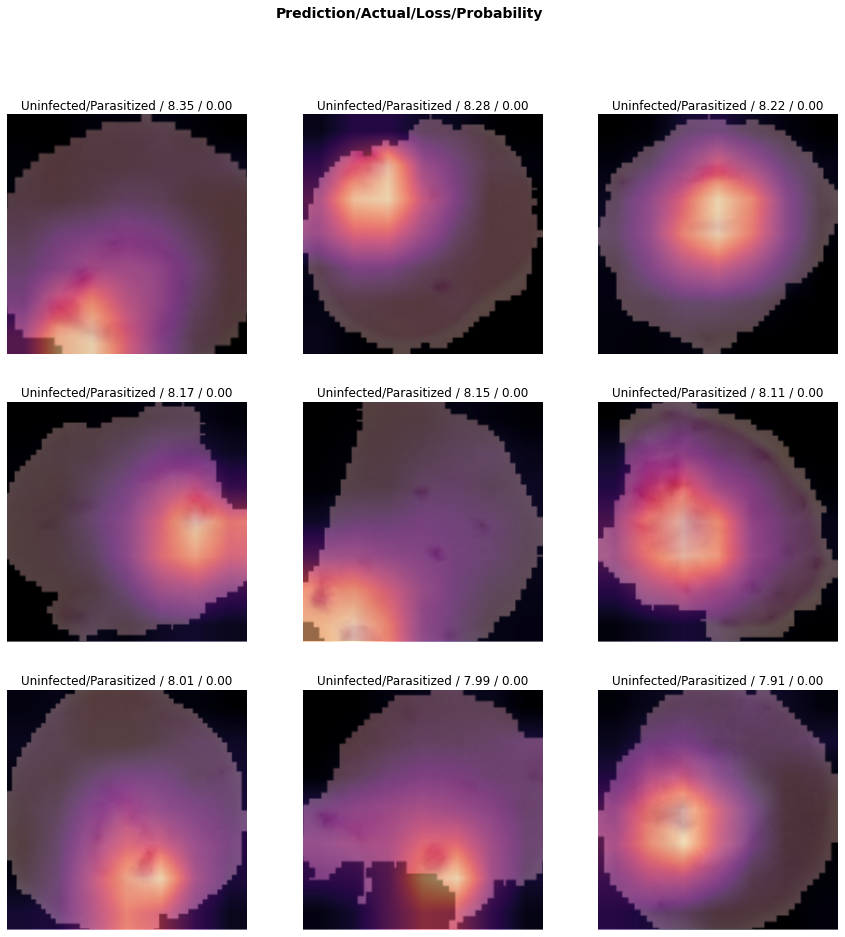

In [0]:
interp.plot_top_losses(9, figsize=(15,15),heatmap=True)

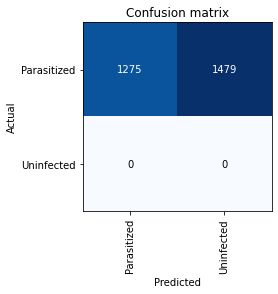

In [0]:
interp.plot_confusion_matrix()